In [1]:
import numpy as np
from control import matlab
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

## 13.2　制御対象の解析

In [2]:
# 問題設定
A = np.array(pd.read_csv("./data/cartpole_model/sys_A.csv",header=None))
B = np.array(pd.read_csv("./data/cartpole_model/sys_B.csv",header=None))
D =0

- なにはともあれ可制御性判別

In [3]:
Uc = matlab.ctrb(A, B)
Rc = np.linalg.matrix_rank(Uc)

In [4]:
print("ランク:",Rc,"サイズ:",min(Uc.shape))

ランク: 4 サイズ: 4


- 次は安定性を見よう

In [5]:
#元の極を見てみる
np.linalg.eig(A)[0]

array([ 0. ,  0. ,  4.4, -4.4])

In [6]:
def show_eig(A):
    plt.figure()
    plt.scatter(np.real(np.linalg.eigvals(A)), np.imag(np.linalg.eigvals(A)))
    plt.axhline(0,-120,5,color="gray")
    plt.axvline(0,-20,20,color="gray")
    plt.show()

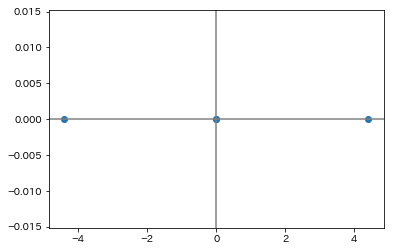

In [7]:
show_eig(A)

- 実部正の固有値を含むので、このままじゃ不安定！

- 次は２つの観測行列の可観測性を比較する

In [8]:
C1 = np.array([1, 0, 0, 0])
C2 = np.array([0, 1, 0, 0])

In [9]:
Uo1 = matlab.obsv(A, C1)
Ro1 = np.linalg.matrix_rank(Uo1)
print("ランク:",Ro1,"サイズ:",min(Uo1.shape))

ランク: 4 サイズ: 4


In [10]:
Uo2 = matlab.obsv(A, C2)
Ro2 = np.linalg.matrix_rank(Uo2)
print("ランク:",Ro2,"サイズ:",min(Uo2.shape))

ランク: 2 サイズ: 4


- C1だったら可観測だけどC2は不可観測になる

- C1を採用して、次はサーボ系が構成可能か調べる

In [11]:
M = np.block([[A, B],[C1, 0]])
np.linalg.eigvals(M)

array([ 4.40276971+0.j        , -4.39730343+0.j        ,
        1.06636093+0.j        , -0.5359136 +0.92525428j,
       -0.5359136 -0.92525428j])

- $M(0) = \left(
    \begin{array}{cc}
      A & B \\
      -C & 0 
    \end{array}
  \right)$
  の固有値に0が入ってないのでサーボ系設計可能

## 13.3 制御系の設計
- まずは状態フィードバックゲイン

In [12]:
Q = np.diag([10]*4)
R1 = 10
R2 = 0.1

In [13]:
F1, X1, E1 = matlab.lqr(A, B, Q, R1)
F2, X2, E2 = matlab.lqr(A, B, Q, R2) 

In [14]:
print(F1, F2)

[[ -1.         -24.64260173  -2.09565197  -5.76696571]] [[-10.         -89.01499274 -16.29019651 -23.08194791]]


- とりま状態が直接観測できる仮定でレギュレータ組んでみる

In [16]:
from pendulum import InvertedPendulum
from pendulum import video
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [17]:
# F1の場合

state = [1.0, np.pi/12, 0, 0] #初期値
angle_history = [state[1]]
x_history = [state[0]]
my_pen = InvertedPendulum(state[0], state[1], False)
u = np.dot(F1, state)[0,0]
u_history = [u]
sampling_time = my_pen.t #[s]
total_sim_time = 15 #[s]

count_list = np.linspace(sampling_time, total_sim_time, int(total_sim_time/sampling_time))
state = np.array(state).reshape(-1,1)

for t in count_list:
    u = -np.dot(F1, state)[0,0]
    _ = my_pen.do_action(u)
    x, x_dot, theta, theta_dot = my_pen.get_state()
    x_history.append(x)
    angle_history.append(theta)
    u_history.append(u)
    state = np.array([x, x_dot, theta, theta_dot]).reshape(-1,1)

count_list = np.insert(count_list, 0, 0)

df = pd.DataFrame()
df["x"] = x_history
df["angle"] = angle_history
df["u"] = u_history
df["t"] = count_list

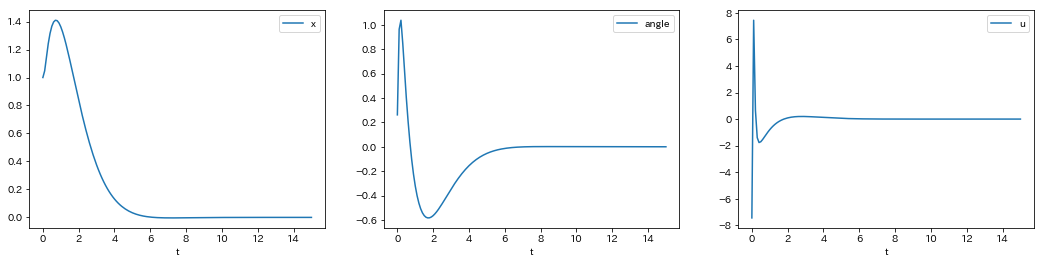

In [18]:
fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

df.plot(ax = ax1, x = "t", y = "x")
df.plot(ax = ax2, x = "t", y = "angle")
df.plot(ax = ax3, x = "t", y = "u")
plt.show()

In [19]:
# F2の場合

state = [1.0, np.pi/12, 0, 0] #初期値
angle_history = [state[1]]
x_history = [state[0]]
my_pen = InvertedPendulum(state[0], state[1], False)
u = np.dot(F1, state)[0,0]
u_history = [u]
sampling_time = my_pen.t #[s]
total_sim_time = 15 #[s]

count_list = np.linspace(sampling_time, total_sim_time, int(total_sim_time/sampling_time))
state = np.array(state).reshape(-1,1)

for t in count_list:
    u = -np.dot(F2, state)[0,0]
    _ = my_pen.do_action(u)
    x, x_dot, theta, theta_dot = my_pen.get_state()
    x_history.append(x)
    angle_history.append(theta)
    u_history.append(u)
    state = np.array([x, x_dot, theta, theta_dot]).reshape(-1,1)

count_list = np.insert(count_list, 0, 0)

df2 = pd.DataFrame()
df2["x"] = x_history
df2["angle"] = angle_history
df2["u"] = u_history
df2["t"] = count_list

/home/inoma/study/contrl_ws/wakariyasui/pendulum.py:43: RuntimeWarning: overflow encountered in double_scalars
  thetaacc = ( ml*sintheta*( Mt*self.g - ml*self.theta_dot**2*costheta ) - self.u*ml*costheta ) / alpha
/home/inoma/study/contrl_ws/wakariyasui/pendulum.py:44: RuntimeWarning: overflow encountered in double_scalars
  xacc = - ( ml*sintheta*( ml*self.g*costheta - Jt*self.theta_dot**2 ) - self.u*Jt ) / alpha
/home/inoma/study/contrl_ws/wakariyasui/pendulum.py:39: RuntimeWarning: invalid value encountered in cos
  costheta = np.cos(self.theta)
/home/inoma/study/contrl_ws/wakariyasui/pendulum.py:40: RuntimeWarning: invalid value encountered in sin
  sintheta = np.sin(self.theta)


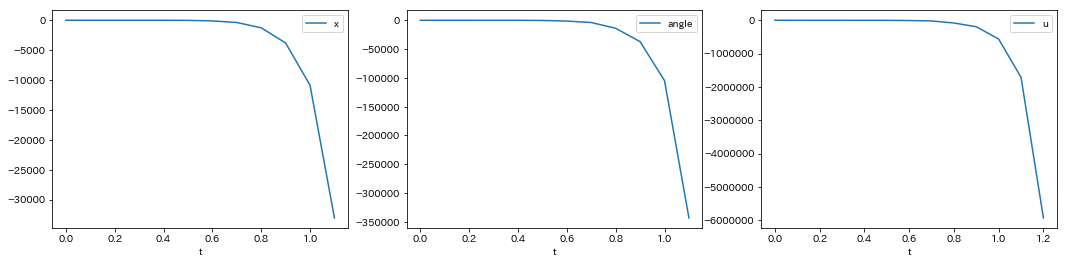

In [20]:
fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

df2.plot(ax = ax1, x = "t", y = "x")
df2.plot(ax = ax2, x = "t", y = "angle")
df2.plot(ax = ax3, x = "t", y = "u")
plt.show()

In [21]:
df2.isna().any()

x         True
angle     True
u         True
t        False
dtype: bool

- なんか、自作のシミュレータが途中ぶっ壊れてる？

MovieWriter imagemagick unavailable.


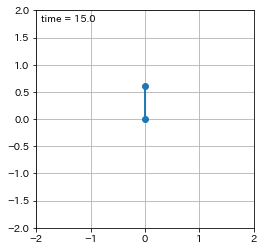

In [22]:
video(np.array(df["x"]), np.array(df["angle"]), my_pen.l, my_pen.t, True)

- 続いてオブザーバーゲイン

In [23]:
A_star = A.T
B_star = C1.T.reshape(-1,1)

- 極配置法で極を移動

In [24]:
poles1 = [-0.8+0.5j, -0.8-0.5j, -0.7, -0.5]
poles2 = [-13+1j, -13-1j, -12, -10]
F_star1 = matlab.place(A_star, B_star, poles1)
F_star2 = matlab.place(A_star, B_star, poles2)
L_1 = F_star1.T
L_2 = F_star2.T

In [25]:
print(L_1,L_2)

[[   2.8       ]
 [ -65.68941176]
 [  22.52      ]
 [-513.29258823]] [[    48.        ]
 [ -9163.85882297]
 [   881.35999996]
 [-44074.27011471]]


In [26]:
# オブザーバの状態方程式
obs = matlab.ss(A-np.dot(L_1, C1.reshape(1,-1)), np.block([B, L_1]), np.eye(4), 0)

In [27]:
#test
y = np.dot(C1, state)
u_hat = np.array([[u],[y[0]]])
u_hat = np.block([np.zeros(2).reshape(-1,1), u_hat])
u_hat
xhat, _, _ = matlab.lsim(obs, u_hat, [0, 0.1], state)

In [28]:
# F1かつ状態量はオブザーバで推定する
# 初期値は真値を与える

state = [1.0, np.pi/12, 0, 0] #初期値
angle_history = [state[1]]
x_history = [state[0]]
my_pen = InvertedPendulum(state[0], state[1], False)
u = np.dot(F1, state)[0,0]
u_history = [u]
sampling_time = my_pen.t #[s]
total_sim_time = 15 #[s]

count_list = np.linspace(sampling_time, total_sim_time, int(total_sim_time/sampling_time))
state = np.array(state).reshape(-1,1)
obs_state = state.copy()

u_hat = np.array([[u],[0]])
u_hat = np.block([np.zeros(2).reshape(-1,1), u_hat])

for t in count_list:
    u = -np.dot(F1, obs_state)[0,0]
    _ = my_pen.do_action(u)
    x, x_dot, theta, theta_dot = my_pen.get_state()

    state = np.array([x, x_dot, theta, theta_dot]).reshape(-1,1)

    y = np.dot(C1, state)
    tmp = np.array([[u],[y[0]]])
    u_hat = np.block([np.zeros(2).reshape(-1,1), tmp])
    
    obs_state, _, _ = matlab.lsim(obs, u_hat, [0, 0.1], obs_state)
    obs_state = obs_state[-1]
    print(state, obs_state)
    
    x_history.append(x)
    angle_history.append(theta)
    u_history.append(u)

count_list = np.insert(count_list, 0, 0)

df = pd.DataFrame()
df["x"] = x_history
df["angle"] = angle_history
df["u"] = u_history
df["t"] = count_list

[[ 1.04770451]
 [ 0.19982886]
 [ 0.96353982]
 [-1.27440564]] [   2.18843093  -27.29932862    7.10176804 -161.84618136]
[[  -8.50002591]
 [   0.74211213]
 [-190.64583764]
 [ -70.55593126]] [ -290.28415701  6755.70708412 -1746.56603057 39803.43983289]
[[ 2285.95018749]
 [ -267.98044567]
 [46242.76291473]
 [-3053.61439532]] [   71818.95450015 -1665596.08980059   430608.85647216 -9813378.54612103]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan n

/home/inoma/study/contrl_ws/wakariyasui/pendulum.py:43: RuntimeWarning: overflow encountered in double_scalars
  thetaacc = ( ml*sintheta*( Mt*self.g - ml*self.theta_dot**2*costheta ) - self.u*ml*costheta ) / alpha
/home/inoma/study/contrl_ws/wakariyasui/pendulum.py:44: RuntimeWarning: overflow encountered in double_scalars
  xacc = - ( ml*sintheta*( ml*self.g*costheta - Jt*self.theta_dot**2 ) - self.u*Jt ) / alpha
/home/inoma/study/contrl_ws/wakariyasui/pendulum.py:49: RuntimeWarning: invalid value encountered in double_scalars
  self.theta_dot += self.t_one * thetaacc
/home/inoma/study/contrl_ws/wakariyasui/pendulum.py:39: RuntimeWarning: invalid value encountered in cos
  costheta = np.cos(self.theta)
/home/inoma/study/contrl_ws/wakariyasui/pendulum.py:40: RuntimeWarning: invalid value encountered in sin
  sintheta = np.sin(self.theta)


[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]
 [nan]
 [nan]] [nan nan nan nan]
[[nan]
 [nan]

In [29]:
df.head(10)

,x,angle,u,t
0,1.000000,0.261799,-7.451418e+00,0.0
1,1.047705,0.963540,7.451418e+00,0.1
2,-8.500026,-190.645838,-1.589017e+03,0.2
3,2285.950187,46242.762915,3.920728e+05,0.3
4,NaN,NaN,-9.666381e+07,0.4
5,NaN,NaN,NaN,0.5
6,NaN,NaN,NaN,0.6
7,NaN,NaN,NaN,0.7
8,NaN,NaN,NaN,0.8
9,NaN,NaN,NaN,0.9
